# BMG SmartReach - MVP de Inteligência em Vendas

### BMG SMARTREACH - MVP DE INTELIGÊNCIA EM VENDAS

**Objetivo**
Personalizar ofertas bancárias respondendo:
1. Quem é o cliente (perfil/cluster)
2. Qual produto sugerir (consignado/cartão/investimento)
3. Por qual canal abordar (WhatsApp/Email/App/SMS)
4. Qual tom de linguagem usar

- **Público-alvo:** Baixa renda e idosos (foco em consignado INSS)
- **Volume:** 20.000+ clientes sintéticos
- **Abordagem:** Pipeline completo com ML + explicabilidade

**Desenvolvedor:** André Cini
**Data:** 2025-16-08

In [1]:
import sys
print(sys.executable)

c:\Users\andre\AppData\Local\Programs\Python\Python312\python.exe


In [2]:
# =============================================================================
# 1. IMPORTS E CONFIGURAÇÃO
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score, roc_auc_score,
                             silhouette_score)

# LightGBM (melhor que RF para esse caso)
try:
    import lightgbm as lgb
    HAS_LIGHTGBM = True
except ImportError:
    HAS_LIGHTGBM = False
    print("⚠️  LightGBM não instalado. Usando RandomForest como fallback.")

# SHAP para explicabilidade
try:
    import shap
    HAS_SHAP = True
except ImportError:
    HAS_SHAP = False
    print("⚠️  SHAP não instalado. Usando feature importance padrão.")

# Reprodutibilidade
SEED = 42
np.random.seed(SEED)

# Configuração de plots
plt.style.use('default')
sns.set_palette("husl")

print("✅ Imports concluídos!")
print(f"📦 LightGBM disponível: {HAS_LIGHTGBM}")
print(f"📦 SHAP disponível: {HAS_SHAP}")

✅ Imports concluídos!
📦 LightGBM disponível: True
📦 SHAP disponível: True


In [7]:
# =============================================================================
# 2. GERAÇÃO DE DADOS SINTÉTICOS REALISTAS
# =============================================================================

print("\n" + "="*80)
print("ETAPA 1: GERAÇÃO DE DADOS SINTÉTICOS")
print("="*80)

def gerar_dados_sinteticos(n_clientes: int = 20000) -> pd.DataFrame:
    """
    Gera dados sintéticos realistas para clientes BMG.
    
    Premissas de negócio:
    - 60% INSS (idosos, baixa renda, alta propensão a consignado)
    - 25% Servidor Público (renda média/alta, propensão a investimento)
    - 15% CLT (jovens, propensão a cartão e app)
    
    Args:
        n_clientes: Número de clientes a gerar
    
    Returns:
        DataFrame com dados sintéticos
    """
    np.random.seed(SEED)
    
    # Distribuição de tipo de benefício (realista para BMG)
    tipo_beneficio = np.random.choice(
        ['INSS', 'Servidor Publico', 'CLT'],
        size=n_clientes,
        p=[0.60, 0.25, 0.15]
    )
    
    # Idade correlacionada com tipo de benefício
    idade = np.zeros(n_clientes)
    for i, tipo in enumerate(tipo_beneficio):
        if tipo == 'INSS':
            idade[i] = np.clip(np.random.normal(62, 12), 50, 90)
        elif tipo == 'Servidor Publico':
            idade[i] = np.clip(np.random.normal(45, 10), 30, 70)
        else:  # CLT
            idade[i] = np.clip(np.random.normal(35, 8), 18, 55)
    
    idade = idade.astype(int)
    
    # Renda correlacionada com tipo e idade
    renda_mensal = np.zeros(n_clientes)
    for i, tipo in enumerate(tipo_beneficio):
        if tipo == 'INSS':
            renda_mensal[i] = np.clip(np.random.gamma(2, 700), 1300, 4000)
        elif tipo == 'Servidor Publico':
            renda_mensal[i] = np.clip(np.random.gamma(3, 2000), 3000, 15000)
        else:  # CLT
            renda_mensal[i] = np.clip(np.random.gamma(2.5, 1000), 1500, 8000)
    
    renda_mensal = renda_mensal.round(2)
    
    # Tempo de casa (relacionamento)
    tempo_de_casa_meses = np.random.gamma(2, 18, n_clientes).astype(int)
    tempo_de_casa_meses = np.clip(tempo_de_casa_meses, 1, 240)
    
    # Uso de canais digitais (correlacionado com idade)
    # Idosos usam mais WhatsApp e SMS, jovens usam mais App e Email
    uso_whatsapp = np.zeros(n_clientes)
    uso_email = np.zeros(n_clientes)
    uso_app = np.zeros(n_clientes)
    uso_sms = np.zeros(n_clientes)
    
    for i in range(n_clientes):
        if idade[i] >= 60:  # Idosos
            uso_whatsapp[i] = np.random.poisson(12)  # Alta
            uso_sms[i] = np.random.poisson(8)
            uso_email[i] = np.random.poisson(2)
            uso_app[i] = np.random.poisson(1)
        elif idade[i] >= 40:  # Meia-idade
            uso_whatsapp[i] = np.random.poisson(15)
            uso_email[i] = np.random.poisson(8)
            uso_app[i] = np.random.poisson(10)
            uso_sms[i] = np.random.poisson(3)
        else:  # Jovens
            uso_app[i] = np.random.poisson(20)  # Alta
            uso_whatsapp[i] = np.random.poisson(10)
            uso_email[i] = np.random.poisson(5)
            uso_sms[i] = np.random.poisson(1)
    
    # Produtos atuais (correlacionados)
    tem_consignado = np.zeros(n_clientes)
    tem_cartao = np.zeros(n_clientes)
    tem_investimento = np.zeros(n_clientes)
    
    for i, tipo in enumerate(tipo_beneficio):
        if tipo == 'INSS':
            tem_consignado[i] = np.random.choice([0, 1], p=[0.3, 0.7])
            tem_cartao[i] = np.random.choice([0, 1], p=[0.7, 0.3])
            tem_investimento[i] = np.random.choice([0, 1], p=[0.95, 0.05])
        elif tipo == 'Servidor Publico':
            tem_consignado[i] = np.random.choice([0, 1], p=[0.5, 0.5])
            tem_cartao[i] = np.random.choice([0, 1], p=[0.4, 0.6])
            tem_investimento[i] = np.random.choice([0, 1], p=[0.6, 0.4])
        else:  # CLT
            tem_consignado[i] = np.random.choice([0, 1], p=[0.8, 0.2])
            tem_cartao[i] = np.random.choice([0, 1], p=[0.3, 0.7])
            tem_investimento[i] = np.random.choice([0, 1], p=[0.85, 0.15])
    
    # Inadimplência (baixa para INSS, média para outros)
    inadimplente_historico = np.zeros(n_clientes)
    for i, tipo in enumerate(tipo_beneficio):
        if tipo == 'INSS':
            inadimplente_historico[i] = np.random.choice([0, 1], p=[0.95, 0.05])
        else:
            inadimplente_historico[i] = np.random.choice([0, 1], p=[0.85, 0.15])
    
    # TARGETS HISTÓRICOS (gerados com regras de negócio)
    produto_alvo_historico = []
    canal_resposta_historico = []
    
    for i in range(n_clientes):
        # Produto alvo baseado em perfil
        if tipo_beneficio[i] == 'INSS' and tem_consignado[i] == 0:
            produto = np.random.choice(['consignado', 'cartao'], p=[0.8, 0.2])
        elif tipo_beneficio[i] == 'Servidor Publico' and tem_investimento[i] == 0:
            produto = np.random.choice(['investimento', 'consignado'], p=[0.6, 0.4])
        elif tipo_beneficio[i] == 'CLT' and tem_cartao[i] == 0:
            produto = np.random.choice(['cartao', 'investimento'], p=[0.7, 0.3])
        else:
            produto = np.random.choice(['consignado', 'cartao', 'investimento'], 
                                      p=[0.5, 0.3, 0.2])
        produto_alvo_historico.append(produto)
        
        # Canal ideal baseado em uso
        canais = ['whatsapp', 'email', 'app', 'sms']
        usos = [uso_whatsapp[i], uso_email[i], uso_app[i], uso_sms[i]]
        # Canal com maior uso tem maior probabilidade
        probs = np.array(usos) + 1  # +1 para evitar zero
        probs = probs / probs.sum()
        canal = np.random.choice(canais, p=probs)
        canal_resposta_historico.append(canal)
    
    # Montar DataFrame
    df = pd.DataFrame({
        'cliente_id': [f'CLI_{i:06d}' for i in range(n_clientes)],
        'idade': idade,
        'renda_mensal': renda_mensal,
        'tempo_de_casa_meses': tempo_de_casa_meses,
        'tipo_beneficio': tipo_beneficio,
        'uso_whatsapp': uso_whatsapp.astype(int),
        'uso_email': uso_email.astype(int),
        'uso_app': uso_app.astype(int),
        'uso_sms': uso_sms.astype(int),
        'tem_consignado': tem_consignado.astype(int),
        'tem_cartao': tem_cartao.astype(int),
        'tem_investimento': tem_investimento.astype(int),
        'inadimplente_historico': inadimplente_historico.astype(int),
        'produto_alvo_historico': produto_alvo_historico,
        'canal_resposta_historico': canal_resposta_historico
    })
    
    return df

# Gerar dados
df = gerar_dados_sinteticos(n_clientes=20000)

print(f"✅ Dados gerados: {len(df):,} clientes")
print(f"\n📊 Primeiras linhas:")
print(df.head(10))
print(f"\n📈 Estatísticas descritivas:")
print(df.describe())
print(f"\n🎯 Distribuição de produtos alvo:")
print(df['produto_alvo_historico'].value_counts())
print(f"\n📱 Distribuição de canais:")
print(df['canal_resposta_historico'].value_counts())



ETAPA 1: GERAÇÃO DE DADOS SINTÉTICOS
✅ Dados gerados: 20,000 clientes

📊 Primeiras linhas:
   cliente_id  idade  renda_mensal  tempo_de_casa_meses    tipo_beneficio  \
0  CLI_000000     52       1761.04                   10              INSS   
1  CLI_000001     39       2401.51                   70               CLT   
2  CLI_000002     58       7331.47                   49  Servidor Publico   
3  CLI_000003     50       1300.00                   53              INSS   
4  CLI_000004     82       1300.00                   26              INSS   
5  CLI_000005     60       1300.00                   67              INSS   
6  CLI_000006     50       1587.85                   37              INSS   
7  CLI_000007     41       2239.53                   31               CLT   
8  CLI_000008     40       4767.78                   21  Servidor Publico   
9  CLI_000009     44       4956.11                   19  Servidor Publico   

   uso_whatsapp  uso_email  uso_app  uso_sms  tem_consignado

In [8]:
# =============================================================================
# 3. ENGENHARIA DE FEATURES
# =============================================================================

print("\n" + "="*80)
print("ETAPA 2: ENGENHARIA DE FEATURES")
print("="*80)

def criar_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cria features derivadas para melhorar poder preditivo.
    
    Features criadas:
    - RFM de canais (recência/frequência)
    - Interações (idade x canal, renda x inadimplência)
    - Razões e flags
    """
    df = df.copy()
    
    # Total de uso digital
    df['uso_digital_total'] = (df['uso_whatsapp'] + df['uso_email'] + 
                                df['uso_app'] + df['uso_sms'])
    
    # Canal preferido (o mais usado)
    canais = ['uso_whatsapp', 'uso_email', 'uso_app', 'uso_sms']
    df['canal_preferido_idx'] = df[canais].values.argmax(axis=1)
    
    # Razão de uso app/total (digitalização)
    df['taxa_uso_app'] = df['uso_app'] / (df['uso_digital_total'] + 1)
    df['taxa_uso_whatsapp'] = df['uso_whatsapp'] / (df['uso_digital_total'] + 1)
    
    # Interações importantes
    df['idade_x_uso_app'] = df['idade'] * df['uso_app']
    df['renda_x_inadimplencia'] = df['renda_mensal'] * df['inadimplente_historico']
    
    # Tempo de casa (categorizado)
    df['tempo_casa_anos'] = df['tempo_de_casa_meses'] / 12
    df['cliente_novo'] = (df['tempo_de_casa_meses'] < 12).astype(int)
    
    # Quantidade de produtos
    df['qtd_produtos'] = (df['tem_consignado'] + df['tem_cartao'] + 
                          df['tem_investimento'])
    
    # Flag de idoso
    df['e_idoso'] = (df['idade'] >= 60).astype(int)
    
    # Renda categorizada
    df['faixa_renda'] = pd.cut(df['renda_mensal'], 
                                bins=[0, 2000, 4000, 8000, 20000],
                                labels=['muito_baixa', 'baixa', 'media', 'alta'])
    
    # Encoding de categorias
    le_beneficio = LabelEncoder()
    df['tipo_beneficio_encoded'] = le_beneficio.fit_transform(df['tipo_beneficio'])
    
    le_faixa_renda = LabelEncoder()
    df['faixa_renda_encoded'] = le_faixa_renda.fit_transform(df['faixa_renda'])
    
    print("✅ Features criadas:")
    novas_features = ['uso_digital_total', 'canal_preferido_idx', 'taxa_uso_app',
                     'taxa_uso_whatsapp', 'idade_x_uso_app', 'tempo_casa_anos',
                     'cliente_novo', 'qtd_produtos', 'e_idoso']
    for feat in novas_features:
        print(f"   - {feat}")
    
    return df

df = criar_features(df)

print(f"\n📊 Shape após feature engineering: {df.shape}")
print(f"\n🔍 Amostra de novas features:")
print(df[['cliente_id', 'uso_digital_total', 'taxa_uso_app', 
          'qtd_produtos', 'e_idoso']].head())


ETAPA 2: ENGENHARIA DE FEATURES
✅ Features criadas:
   - uso_digital_total
   - canal_preferido_idx
   - taxa_uso_app
   - taxa_uso_whatsapp
   - idade_x_uso_app
   - tempo_casa_anos
   - cliente_novo
   - qtd_produtos
   - e_idoso

📊 Shape após feature engineering: (20000, 28)

🔍 Amostra de novas features:
   cliente_id  uso_digital_total  taxa_uso_app  qtd_produtos  e_idoso
0  CLI_000000                 32      0.272727             1        0
1  CLI_000001                 31      0.687500             2        0
2  CLI_000002                 37      0.210526             2        0
3  CLI_000003                 46      0.276596             2        0
4  CLI_000004                 23      0.000000             0        1



ETAPA 3: CLUSTERIZAÇÃO DE PERFIS
🔍 Analisando número ideal de clusters...


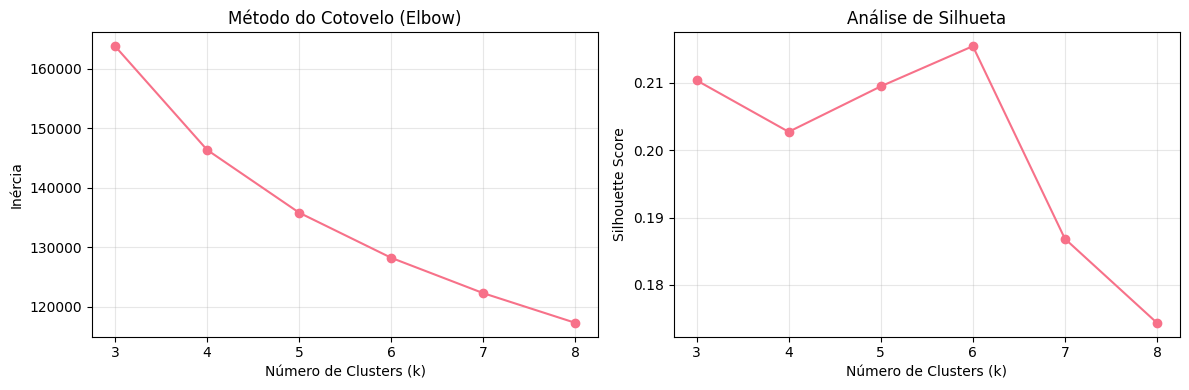


✅ Usando k=5 clusters
📊 Silhouette Score: 0.209

🎯 Distribuição de clusters:
cluster
0    1735
1    6719
2    3622
3    5587
4    2337
Name: count, dtype: int64

INTERPRETAÇÃO DOS CLUSTERS

📊 Perfil médio por cluster:
         idade  renda_mensal  tempo_de_casa_meses  uso_whatsapp  uso_email  \
cluster                                                                      
0        46.45       3953.98                35.03         12.89       6.03   
1        69.63       1772.67                35.35         11.95       2.00   
2        43.56       6464.70                35.78         13.04       6.69   
3        52.45       1873.54                35.81         15.34       8.12   
4        33.58       2666.47                35.85         10.76       5.49   

         uso_app  uso_sms  tem_consignado  tem_cartao  tem_investimento  \
cluster                                                                   
0          11.95     3.00            0.47        0.53              0.23   
1        

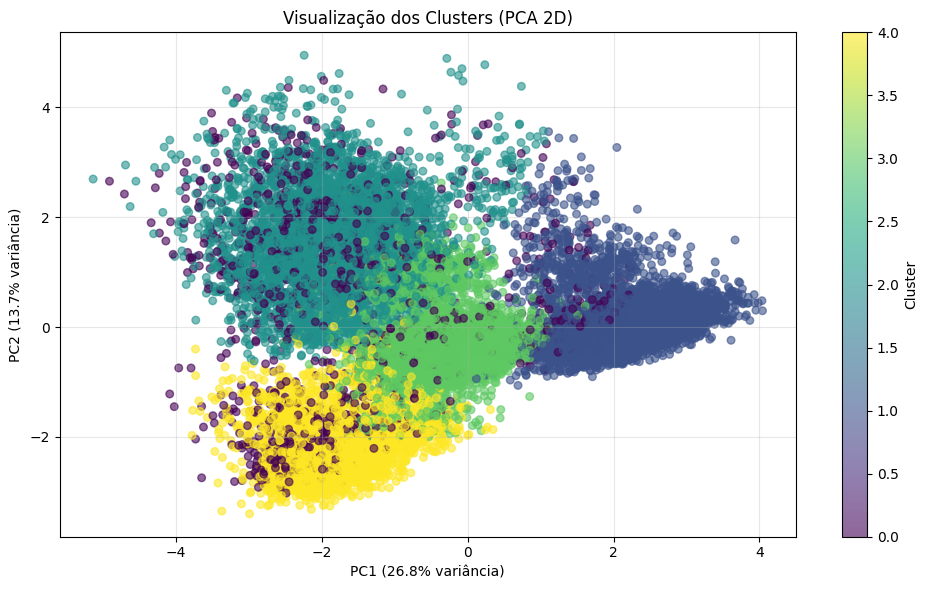

✅ Variância explicada: 40.5%


In [9]:
# =============================================================================
# 4. CLUSTERIZAÇÃO DE PERFIS
# =============================================================================

print("\n" + "="*80)
print("ETAPA 3: CLUSTERIZAÇÃO DE PERFIS")
print("="*80)

def clusterizar_perfis(df: pd.DataFrame, n_clusters: int = 5) -> Tuple[pd.DataFrame, KMeans, StandardScaler]:
    """
    Agrupa clientes por comportamento usando K-Means.
    
    Melhorias implementadas:
    - Análise de elbow e silhouette para escolher k
    - StandardScaler para normalização
    - PCA para visualização
    """
    # Features para clustering
    features_cluster = [
        'idade', 'renda_mensal', 'tempo_de_casa_meses',
        'uso_whatsapp', 'uso_email', 'uso_app', 'uso_sms',
        'tem_consignado', 'tem_cartao', 'tem_investimento',
        'inadimplente_historico', 'tipo_beneficio_encoded'
    ]
    
    X_cluster = df[features_cluster].values
    
    # Padronização
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)
    
    # Análise de elbow (testar k de 3 a 8)
    print("🔍 Analisando número ideal de clusters...")
    inertias = []
    silhouettes = []
    k_range = range(3, 9)
    
    for k in k_range:
        kmeans_temp = KMeans(n_clusters=k, random_state=SEED, n_init=10)
        kmeans_temp.fit(X_scaled)
        inertias.append(kmeans_temp.inertia_)
        silhouettes.append(silhouette_score(X_scaled, kmeans_temp.labels_))
    
    # Plot elbow
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(k_range, inertias, marker='o')
    ax1.set_xlabel('Número de Clusters (k)')
    ax1.set_ylabel('Inércia')
    ax1.set_title('Método do Cotovelo (Elbow)')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(k_range, silhouettes, marker='o')
    ax2.set_xlabel('Número de Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Análise de Silhueta')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # K-Means final
    print(f"\n✅ Usando k={n_clusters} clusters")
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init=10)
    df['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Silhouette score final
    sil_score = silhouette_score(X_scaled, df['cluster'])
    print(f"📊 Silhouette Score: {sil_score:.3f}")
    
    return df, kmeans, scaler

df, kmeans_model, scaler_cluster = clusterizar_perfis(df, n_clusters=5)

print(f"\n🎯 Distribuição de clusters:")
print(df['cluster'].value_counts().sort_index())


# Interpretação dos clusters
print("\n" + "="*80)
print("INTERPRETAÇÃO DOS CLUSTERS")
print("="*80)

def interpretar_clusters(df: pd.DataFrame) -> pd.DataFrame:
    """Gera tabela de interpretação por cluster."""
    
    interpretacao = df.groupby('cluster').agg({
        'idade': 'mean',
        'renda_mensal': 'mean',
        'tempo_de_casa_meses': 'mean',
        'uso_whatsapp': 'mean',
        'uso_email': 'mean',
        'uso_app': 'mean',
        'uso_sms': 'mean',
        'tem_consignado': 'mean',
        'tem_cartao': 'mean',
        'tem_investimento': 'mean',
        'e_idoso': 'mean',
        'cliente_id': 'count'
    }).round(2)
    
    interpretacao.rename(columns={'cliente_id': 'total_clientes'}, inplace=True)
    
    return interpretacao

tabela_clusters = interpretar_clusters(df)
print("\n📊 Perfil médio por cluster:")
print(tabela_clusters)

# Nomear clusters baseado no perfil
nomes_clusters = {}
for cluster_id in range(5):
    perfil = tabela_clusters.loc[cluster_id]
    
    if perfil['e_idoso'] > 0.7 and perfil['tem_consignado'] > 0.6:
        nome = "Idosos Consignados"
    elif perfil['renda_mensal'] > 6000 and perfil['tem_investimento'] > 0.3:
        nome = "Alta Renda Investidores"
    elif perfil['uso_app'] > 15 and perfil['idade'] < 40:
        nome = "Jovens Digitais"
    elif perfil['uso_whatsapp'] > 10:
        nome = "WhatsApp Lovers"
    else:
        nome = f"Cluster {cluster_id}"
    
    nomes_clusters[cluster_id] = nome

df['cluster_nome'] = df['cluster'].map(nomes_clusters)

print("\n🏷️  Nomenclatura dos clusters:")
for k, v in nomes_clusters.items():
    print(f"   Cluster {k}: {v}")


# Visualização PCA 2D
print("\n📊 Gerando visualização PCA dos clusters...")

# Usar as MESMAS features do clustering para evitar erro de dimensão
features_viz = [
    'idade', 'renda_mensal', 'tempo_de_casa_meses',
    'uso_whatsapp', 'uso_email', 'uso_app', 'uso_sms',
    'tem_consignado', 'tem_cartao', 'tem_investimento',
    'inadimplente_historico', 'tipo_beneficio_encoded'
]

X_viz = df[features_viz].values
X_viz_scaled = scaler_cluster.transform(X_viz)

pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_viz_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], 
                     alpha=0.6, s=30, cmap='viridis')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variância)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variância)')
plt.title('Visualização dos Clusters (PCA 2D)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Variância explicada: {pca.explained_variance_ratio_.sum():.1%}")


ETAPA 4: MODELAGEM DE PROPENSÃO AO PRODUTO
📊 Train: 16,000 | Test: 4,000
🎯 Classes: ['cartao' 'consignado' 'investimento']

🚀 Usando LightGBM (otimizado)
🔧 Treinando modelo...

✅ Accuracy: 0.573
✅ F1-Score (macro): 0.461

📊 Classification Report:
              precision    recall  f1-score   support

      cartao       0.54      0.16      0.24      1030
  consignado       0.57      0.87      0.69      2066
investimento       0.60      0.36      0.45       904

    accuracy                           0.57      4000
   macro avg       0.57      0.46      0.46      4000
weighted avg       0.57      0.57      0.52      4000



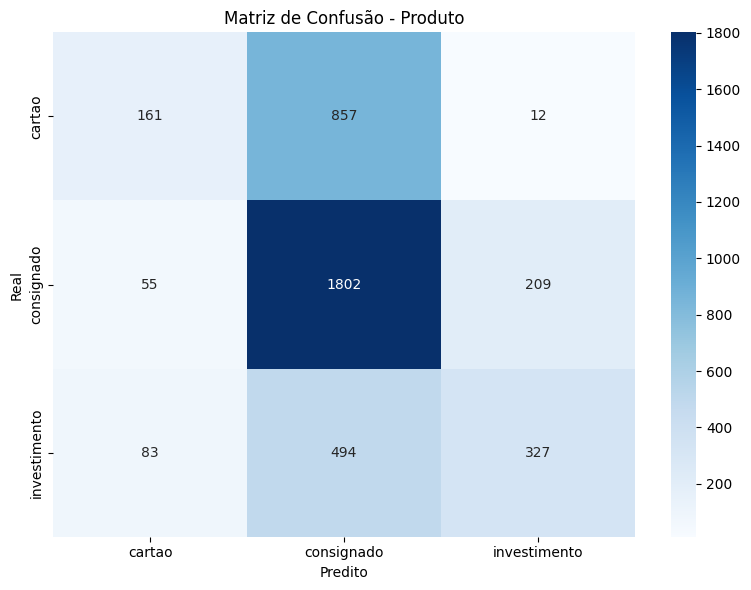


📈 Top 10 Features Mais Importantes:
                   feature  importance
6        taxa_uso_whatsapp        2942
2      tempo_de_casa_meses        2885
1             renda_mensal        2560
5             taxa_uso_app        2546
0                    idade        2105
4        uso_digital_total        1951
11            qtd_produtos         490
3   tipo_beneficio_encoded         430
8               tem_cartao         363
7           tem_consignado         345


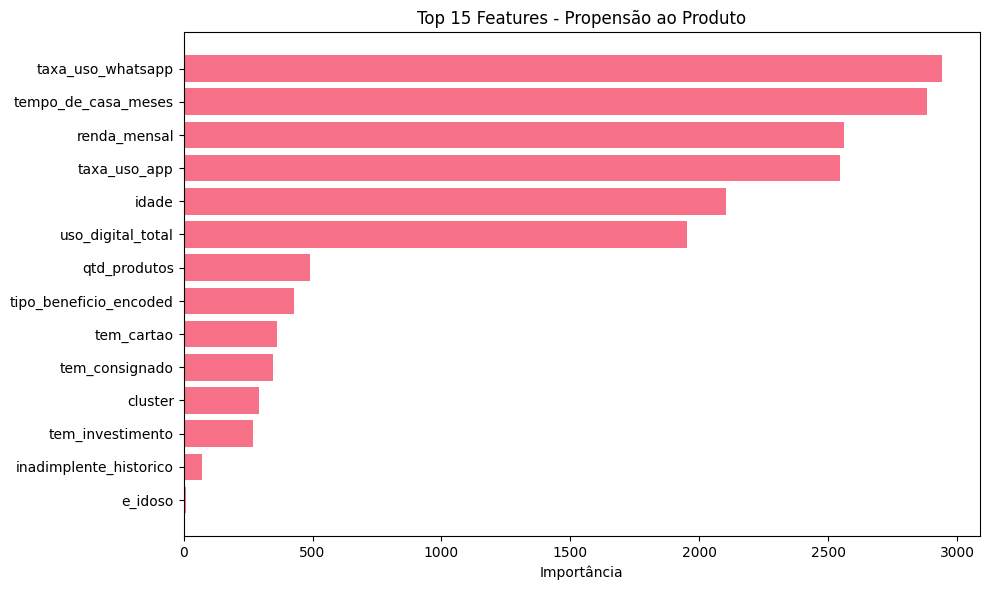


🔄 Validação cruzada (5-fold)...
   F1-Score CV: 0.456 (+/- 0.008)

✅ Modelo de produto treinado com sucesso!


In [10]:
# =============================================================================
# 5. PROPENSÃO AO PRODUTO
# =============================================================================

print("\n" + "="*80)
print("ETAPA 4: MODELAGEM DE PROPENSÃO AO PRODUTO")
print("="*80)

def treinar_modelo_produto(df: pd.DataFrame):
    """
    Treina modelo para prever produto com maior propensão.
    
    MELHORIA IMPLEMENTADA: LightGBM ao invés de RandomForest
    - Mais rápido e eficiente
    - Melhor com variáveis categóricas
    - Menor overfitting
    """
    # Features para modelo
    features_modelo = [
        'idade', 'renda_mensal', 'tempo_de_casa_meses',
        'tipo_beneficio_encoded', 'uso_digital_total',
        'taxa_uso_app', 'taxa_uso_whatsapp',
        'tem_consignado', 'tem_cartao', 'tem_investimento',
        'inadimplente_historico', 'qtd_produtos', 'e_idoso',
        'cluster'
    ]
    
    X = df[features_modelo].values
    y = df['produto_alvo_historico'].values
    
    # Encoding do target
    le_produto = LabelEncoder()
    y_encoded = le_produto.fit_transform(y)
    
    # Split estratificado
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded
    )
    
    print(f"📊 Train: {len(X_train):,} | Test: {len(X_test):,}")
    print(f"🎯 Classes: {le_produto.classes_}")
    
    # Modelo
    if HAS_LIGHTGBM:
        print("\n🚀 Usando LightGBM (otimizado)")
        model = lgb.LGBMClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=7,
            num_leaves=31,
            min_child_samples=20,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=SEED,
            verbose=-1
        )
    else:
        print("\n🌲 Usando RandomForest (fallback)")
        model = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=SEED,
            n_jobs=-1
        )
    
    # Treino
    print("🔧 Treinando modelo...")
    model.fit(X_train, y_train)
    
    # Predições
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    print(f"\n✅ Accuracy: {acc:.3f}")
    print(f"✅ F1-Score (macro): {f1_macro:.3f}")
    
    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, 
                               target_names=le_produto.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le_produto.classes_,
                yticklabels=le_produto.classes_)
    plt.title('Matriz de Confusão - Produto')
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.tight_layout()
    plt.show()
    
    # Feature Importance
    if HAS_LIGHTGBM:
        importances = model.feature_importances_
    else:
        importances = model.feature_importances_
    
    feat_imp = pd.DataFrame({
        'feature': features_modelo,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("\n📈 Top 10 Features Mais Importantes:")
    print(feat_imp.head(10))
    
    # Plot importâncias
    plt.figure(figsize=(10, 6))
    top_features = feat_imp.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importância')
    plt.title('Top 15 Features - Propensão ao Produto')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Validação cruzada
    print("\n🔄 Validação cruzada (5-fold)...")
    cv_scores = cross_val_score(model, X_train, y_train, 
                                cv=StratifiedKFold(5, shuffle=True, random_state=SEED),
                                scoring='f1_macro', n_jobs=-1)
    print(f"   F1-Score CV: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")
    
    return model, le_produto, features_modelo, X_test, y_test, y_pred_proba

modelo_produto, le_produto, features_produto, X_test_prod, y_test_prod, y_proba_prod = treinar_modelo_produto(df)

print("\n✅ Modelo de produto treinado com sucesso!")


ETAPA 5: MODELAGEM DE CANAL IDEAL
📊 Train: 16,000 | Test: 4,000
📱 Canais: ['app' 'email' 'sms' 'whatsapp']

🚀 Usando LightGBM com class_weight
🔧 Treinando modelo de canal...

✅ Accuracy: 0.372
✅ F1-Score (macro): 0.371
✅ Top-2 Accuracy: 0.694

📊 Classification Report:
              precision    recall  f1-score   support

         app       0.43      0.51      0.46       982
       email       0.24      0.38      0.29       674
         sms       0.34      0.59      0.43       684
    whatsapp       0.58      0.20      0.30      1660

    accuracy                           0.37      4000
   macro avg       0.40      0.42      0.37      4000
weighted avg       0.44      0.37      0.36      4000



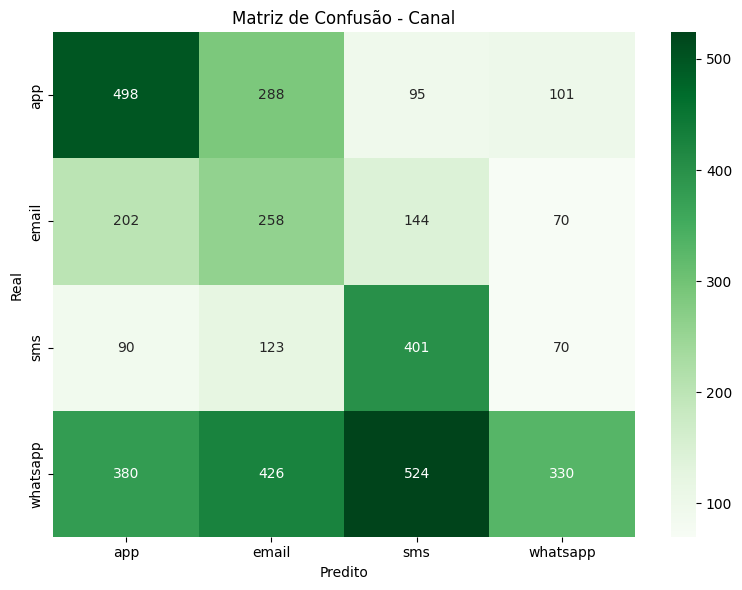


📈 Top 10 Features - Canal:
              feature  importance
9   taxa_uso_whatsapp        2768
1        renda_mensal        2457
8        taxa_uso_app        2157
0               idade        2066
7   uso_digital_total        1655
4           uso_email        1309
6             uso_sms        1272
3        uso_whatsapp        1041
5             uso_app         628
12       qtd_produtos         480

✅ Modelo de canal treinado com sucesso!


In [11]:
# =============================================================================
# 6. MODELO DE CANAL IDEAL
# =============================================================================

print("\n" + "="*80)
print("ETAPA 5: MODELAGEM DE CANAL IDEAL")
print("="*80)

def treinar_modelo_canal(df: pd.DataFrame):
    """
    Treina modelo para prever canal com maior chance de resposta.
    
    MELHORIA: LightGBM com class_weight para lidar com desbalanceamento
    """
    features_canal = [
        'idade', 'renda_mensal', 'tipo_beneficio_encoded',
        'uso_whatsapp', 'uso_email', 'uso_app', 'uso_sms',
        'uso_digital_total', 'taxa_uso_app', 'taxa_uso_whatsapp',
        'e_idoso', 'cluster', 'qtd_produtos'
    ]
    
    X = df[features_canal].values
    y = df['canal_resposta_historico'].values
    
    # Encoding
    le_canal = LabelEncoder()
    y_encoded = le_canal.fit_transform(y)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded
    )
    
    print(f"📊 Train: {len(X_train):,} | Test: {len(X_test):,}")
    print(f"📱 Canais: {le_canal.classes_}")
    
    # Modelo
    if HAS_LIGHTGBM:
        print("\n🚀 Usando LightGBM com class_weight")
        model = lgb.LGBMClassifier(
            n_estimators=150,
            learning_rate=0.05,
            max_depth=6,
            num_leaves=31,
            min_child_samples=20,
            class_weight='balanced',
            random_state=SEED,
            verbose=-1
        )
    else:
        print("\n📊 Usando Logistic Regression (baseline)")
        model = LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=SEED,
            n_jobs=-1
        )
    
    # Treino
    print("🔧 Treinando modelo de canal...")
    model.fit(X_train, y_train)
    
    # Predições
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    print(f"\n✅ Accuracy: {acc:.3f}")
    print(f"✅ F1-Score (macro): {f1_macro:.3f}")
    
    # Top-2 Accuracy (importante para canal)
    top2_correct = 0
    for i, true_label in enumerate(y_test):
        top2_preds = np.argsort(y_pred_proba[i])[-2:]
        if true_label in top2_preds:
            top2_correct += 1
    top2_acc = top2_correct / len(y_test)
    print(f"✅ Top-2 Accuracy: {top2_acc:.3f}")
    
    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, 
                               target_names=le_canal.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=le_canal.classes_,
                yticklabels=le_canal.classes_)
    plt.title('Matriz de Confusão - Canal')
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.tight_layout()
    plt.show()
    
    # Feature Importance (se disponível)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feat_imp = pd.DataFrame({
            'feature': features_canal,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print("\n📈 Top 10 Features - Canal:")
        print(feat_imp.head(10))
    
    return model, le_canal, features_canal, X_test, y_test, y_pred_proba

modelo_canal, le_canal, features_canal, X_test_canal, y_test_canal, y_proba_canal = treinar_modelo_canal(df)

print("\n✅ Modelo de canal treinado com sucesso!")

In [12]:
# =============================================================================
# 7. TOM DE LINGUAGEM (MAPEAMENTO POR CLUSTER)
# =============================================================================

print("\n" + "="*80)
print("ETAPA 6: DEFINIÇÃO DE TOM DE LINGUAGEM")
print("="*80)

# Mapeamento de tom por cluster (baseado no perfil)
TOM_LINGUAGEM = {
    0: {
        'nome': 'Empática e Simples',
        'descricao': 'Linguagem acolhedora, frases curtas, evita jargões',
        'exemplo': 'Olá {nome}! Temos uma novidade especial pra você. Quer saber mais?'
    },
    1: {
        'nome': 'Educacional',
        'descricao': 'Explica benefícios, foca em segurança e confiança',
        'exemplo': 'Olá {nome}! Preparamos uma proposta personalizada que pode ajudar você.'
    },
    2: {
        'nome': 'Direta e Moderna',
        'descricao': 'Objetiva, usa emojis moderadamente, tom jovem',
        'exemplo': 'E aí, {nome}! 🚀 Bora conferir uma oferta feita pra você?'
    },
    3: {
        'nome': 'Profissional',
        'descricao': 'Formal mas acessível, foca em vantagens financeiras',
        'exemplo': 'Prezado(a) {nome}, identificamos uma oportunidade exclusiva para você.'
    },
    4: {
        'nome': 'Consultiva',
        'descricao': 'Tom de parceiro financeiro, personalizada',
        'exemplo': 'Olá {nome}, como seu parceiro financeiro, encontramos algo interessante.'
    }
}

def atribuir_tom_linguagem(df: pd.DataFrame) -> pd.DataFrame:
    """Atribui tom de linguagem baseado no cluster."""
    df = df.copy()
    df['tom_linguagem'] = df['cluster'].map(lambda x: TOM_LINGUAGEM[x]['nome'])
    df['tom_descricao'] = df['cluster'].map(lambda x: TOM_LINGUAGEM[x]['descricao'])
    return df

df = atribuir_tom_linguagem(df)

print("🎨 Tons de linguagem definidos por cluster:")
for cluster_id, info in TOM_LINGUAGEM.items():
    nome_cluster = nomes_clusters.get(cluster_id, f"Cluster {cluster_id}")
    print(f"\n   {nome_cluster} (Cluster {cluster_id}):")
    print(f"   Tom: {info['nome']}")
    print(f"   Descrição: {info['descricao']}")
    print(f"   Exemplo: {info['exemplo']}")


ETAPA 6: DEFINIÇÃO DE TOM DE LINGUAGEM
🎨 Tons de linguagem definidos por cluster:

   WhatsApp Lovers (Cluster 0):
   Tom: Empática e Simples
   Descrição: Linguagem acolhedora, frases curtas, evita jargões
   Exemplo: Olá {nome}! Temos uma novidade especial pra você. Quer saber mais?

   Idosos Consignados (Cluster 1):
   Tom: Educacional
   Descrição: Explica benefícios, foca em segurança e confiança
   Exemplo: Olá {nome}! Preparamos uma proposta personalizada que pode ajudar você.

   Alta Renda Investidores (Cluster 2):
   Tom: Direta e Moderna
   Descrição: Objetiva, usa emojis moderadamente, tom jovem
   Exemplo: E aí, {nome}! 🚀 Bora conferir uma oferta feita pra você?

   WhatsApp Lovers (Cluster 3):
   Tom: Profissional
   Descrição: Formal mas acessível, foca em vantagens financeiras
   Exemplo: Prezado(a) {nome}, identificamos uma oportunidade exclusiva para você.

   Jovens Digitais (Cluster 4):
   Tom: Consultiva
   Descrição: Tom de parceiro financeiro, personalizada
   

In [13]:
# =============================================================================
# 8. MOTOR DE RECOMENDAÇÃO (CONSOLIDAÇÃO)
# =============================================================================

print("\n" + "="*80)
print("ETAPA 7: MOTOR DE RECOMENDAÇÃO - CONSOLIDAÇÃO")
print("="*80)

def gerar_recomendacoes(df: pd.DataFrame, modelo_produto, le_produto, 
                        features_produto, modelo_canal, le_canal, 
                        features_canal) -> pd.DataFrame:
    """
    Consolida todas as predições em recomendações finais.
    """
    print("🔧 Gerando recomendações personalizadas...")
    
    df_rec = df.copy()
    
    # Predições de produto
    X_prod = df_rec[features_produto].values
    pred_produto = modelo_produto.predict(X_prod)
    proba_produto = modelo_produto.predict_proba(X_prod)
    
    df_rec['produto_recomendado'] = le_produto.inverse_transform(pred_produto)
    df_rec['score_produto'] = proba_produto.max(axis=1)
    
    # Top 2 produtos
    top2_idx = np.argsort(proba_produto, axis=1)[:, -2:]
    df_rec['produto_alternativo'] = le_produto.inverse_transform(top2_idx[:, 0])
    df_rec['score_alternativo'] = proba_produto[np.arange(len(proba_produto)), top2_idx[:, 0]]
    
    # Predições de canal
    X_canal = df_rec[features_canal].values
    pred_canal = modelo_canal.predict(X_canal)
    proba_canal = modelo_canal.predict_proba(X_canal)
    
    df_rec['canal_recomendado'] = le_canal.inverse_transform(pred_canal)
    df_rec['score_canal'] = proba_canal.max(axis=1)
    
    # Score combinado (ponderado)
    df_rec['score_final'] = (df_rec['score_produto'] * 0.7 + 
                             df_rec['score_canal'] * 0.3)
    
    # Explicação simplificada
    def gerar_explicacao(row):
        explicacoes = []
        
        if row['e_idoso']:
            explicacoes.append('Perfil idoso')
        if row['renda_mensal'] < 3000:
            explicacoes.append('Renda compatível')
        if row['uso_whatsapp'] > 10:
            explicacoes.append('Alto uso WhatsApp')
        if row['tem_consignado'] == 0 and row['produto_recomendado'] == 'consignado':
            explicacoes.append('Não possui produto')
        if row['qtd_produtos'] < 2:
            explicacoes.append('Oportunidade cross-sell')
        
        return ' | '.join(explicacoes[:3]) if explicacoes else 'Análise comportamental'
    
    df_rec['explicacao'] = df_rec.apply(gerar_explicacao, axis=1)
    
    # Prioridade (alta/média/baixa baseado em score)
    df_rec['prioridade'] = pd.cut(df_rec['score_final'], 
                                   bins=[0, 0.5, 0.7, 1.0],
                                   labels=['Baixa', 'Média', 'Alta'])
    
    # Ordenar por score final
    df_rec = df_rec.sort_values('score_final', ascending=False).reset_index(drop=True)
    
    print(f"✅ {len(df_rec):,} recomendações geradas!")
    
    return df_rec

df_recomendacoes = gerar_recomendacoes(df, modelo_produto, le_produto, features_produto,
                                        modelo_canal, le_canal, features_canal)

# Exibir top 20 recomendações
print("\n📊 TOP 20 RECOMENDAÇÕES:")
colunas_exibir = ['cliente_id', 'cluster_nome', 'idade', 'renda_mensal',
                  'produto_recomendado', 'score_produto',
                  'canal_recomendado', 'score_canal', 
                  'score_final', 'prioridade', 'explicacao']

print(df_recomendacoes[colunas_exibir].head(20).to_string(index=False))

# Distribuição de recomendações
print("\n📈 Distribuição de produtos recomendados:")
print(df_recomendacoes['produto_recomendado'].value_counts())

print("\n📱 Distribuição de canais recomendados:")
print(df_recomendacoes['canal_recomendado'].value_counts())

print("\n⚡ Distribuição de prioridades:")
print(df_recomendacoes['prioridade'].value_counts())


ETAPA 7: MOTOR DE RECOMENDAÇÃO - CONSOLIDAÇÃO
🔧 Gerando recomendações personalizadas...
✅ 20,000 recomendações geradas!

📊 TOP 20 RECOMENDAÇÕES:
cliente_id            cluster_nome  idade  renda_mensal produto_recomendado  score_produto canal_recomendado  score_canal  score_final prioridade                                                explicacao
CLI_019866      Idosos Consignados     72       2312.00          consignado       0.907344               sms     0.849559     0.890008       Alta      Perfil idoso | Renda compatível | Não possui produto
CLI_005588         Jovens Digitais     20       4094.13              cartao       0.919875               app     0.774515     0.876267       Alta                                    Análise comportamental
CLI_013750         WhatsApp Lovers     50       1300.00          consignado       0.925091               app     0.695775     0.856296       Alta Renda compatível | Alto uso WhatsApp | Não possui produto
CLI_011525 Alta Renda Investidores    

In [14]:
# =============================================================================
# 9. GERAÇÃO DE MENSAGENS PERSONALIZADAS
# =============================================================================

print("\n" + "="*80)
print("ETAPA 8: GERAÇÃO DE MENSAGENS PERSONALIZADAS")
print("="*80)

def gerar_mensagem(row: pd.Series) -> str:
    """
    Gera mensagem personalizada baseada em produto, canal e tom.
    """
    nome = row['cliente_id'].replace('CLI_', 'Cliente ')
    produto = row['produto_recomendado']
    canal = row['canal_recomendado']
    cluster = row['cluster']
    
    # Template base do tom
    template_base = TOM_LINGUAGEM[cluster]['exemplo']
    
    # Mensagens por produto
    mensagens_produto = {
        'consignado': {
            0: f"Olá! Temos condições especiais em empréstimo consignado pra você. Taxas reduzidas e desconto direto na folha. Posso enviar os detalhes por {canal}?",
            1: f"Olá! Identificamos que você pode se beneficiar do nosso empréstimo consignado. É seguro, com taxas transparentes e desconto automático. Quer saber mais?",
            2: f"E aí! 💰 Liberamos uma oferta de consignado com taxas especiais pra você. Cola no {canal} que te mando os detalhes!",
            3: f"Prezado(a), identificamos uma oportunidade de crédito consignado com condições exclusivas para seu perfil. Gostaria de avaliar?",
            4: f"Como seu parceiro financeiro, encontramos uma proposta de consignado que pode te ajudar. Vamos conversar sobre isso?"
        },
        'cartao': {
            0: f"Oi! Que tal um cartão sem anuidade com cashback em todas as compras? É simples e rápido. Posso te explicar melhor por {canal}?",
            1: f"Olá! Temos um cartão de crédito especial pra você, com benefícios e sem complicação. Quer conhecer as vantagens?",
            2: f"Opa! 💳 Seu cartão com cashback tá pronto! Zero anuidade e vantagens demais. Bora ativar? Te chamo no {canal}!",
            3: f"Prezado(a), disponibilizamos um cartão com condições diferenciadas e programa de benefícios. Gostaria de mais informações?",
            4: f"Identificamos que um cartão de crédito pode complementar seu planejamento financeiro. Vamos analisar juntos?"
        },
        'investimento': {
            0: f"Olá! Sabia que você pode fazer seu dinheiro render mais? Temos investimentos seguros e fáceis de entender. Quer saber como?",
            1: f"Olá! Que tal começar a investir com segurança? Temos opções simples que rendem mais que a poupança. Posso te explicar?",
            2: f"E aí! 📈 Bora fazer o dinheiro trabalhar pra você? Investimentos descomplicados te esperando. Vamos nessa?",
            3: f"Prezado(a), identificamos oportunidades de investimento alinhadas ao seu perfil e objetivos. Gostaria de conhecê-las?",
            4: f"Como parceiro na sua jornada financeira, preparamos alternativas de investimento adequadas ao seu momento. Vamos conversar?"
        }
    }
    
    # Selecionar mensagem
    if produto in mensagens_produto and cluster in mensagens_produto[produto]:
        mensagem = mensagens_produto[produto][cluster]
    else:
        mensagem = template_base.replace('{nome}', nome)
    
    return mensagem

df_recomendacoes['mensagem_personalizada'] = df_recomendacoes.apply(gerar_mensagem, axis=1)

print("✅ Mensagens personalizadas geradas!")
print("\n📱 EXEMPLOS DE MENSAGENS:")

# Mostrar 10 exemplos diversos
exemplos = df_recomendacoes.groupby(['cluster', 'produto_recomendado']).head(1).head(10)

for idx, row in exemplos.iterrows():
    print(f"\n{'='*70}")
    print(f"Cliente: {row['cliente_id']}")
    print(f"Perfil: {row['cluster_nome']} | Produto: {row['produto_recomendado'].upper()}")
    print(f"Canal: {row['canal_recomendado'].upper()} | Tom: {row['tom_linguagem']}")
    print(f"Score: {row['score_final']:.2%} | Prioridade: {row['prioridade']}")
    print(f"\n💬 Mensagem:")
    print(f"   {row['mensagem_personalizada']}")


ETAPA 8: GERAÇÃO DE MENSAGENS PERSONALIZADAS
✅ Mensagens personalizadas geradas!

📱 EXEMPLOS DE MENSAGENS:

Cliente: CLI_019866
Perfil: Idosos Consignados | Produto: CONSIGNADO
Canal: SMS | Tom: Educacional
Score: 89.00% | Prioridade: Alta

💬 Mensagem:
   Olá! Identificamos que você pode se beneficiar do nosso empréstimo consignado. É seguro, com taxas transparentes e desconto automático. Quer saber mais?

Cliente: CLI_005588
Perfil: Jovens Digitais | Produto: CARTAO
Canal: APP | Tom: Consultiva
Score: 87.63% | Prioridade: Alta

💬 Mensagem:
   Identificamos que um cartão de crédito pode complementar seu planejamento financeiro. Vamos analisar juntos?

Cliente: CLI_013750
Perfil: WhatsApp Lovers | Produto: CONSIGNADO
Canal: APP | Tom: Profissional
Score: 85.63% | Prioridade: Alta

💬 Mensagem:
   Prezado(a), identificamos uma oportunidade de crédito consignado com condições exclusivas para seu perfil. Gostaria de avaliar?

Cliente: CLI_011525
Perfil: Alta Renda Investidores | Produto: I


ETAPA 9: KPIs DE NEGÓCIO E SIMULAÇÃO DE IMPACTO
💰 KPIs DE NEGÓCIO (SIMULADOS):

📊 Leads Qualificados: 11,854

🎯 VENDAS:
   Sem IA (baseline): 355 vendas
   Com IA: 948 vendas
   📈 Uplift: +593 vendas (167.0%)

💵 RECEITA (margem):
   Sem IA: R$ 643,446.33
   Com IA: R$ 1,718,273.59
   📈 Uplift: R$ 1,074,827.26

💎 ROI Estimado: 1075%


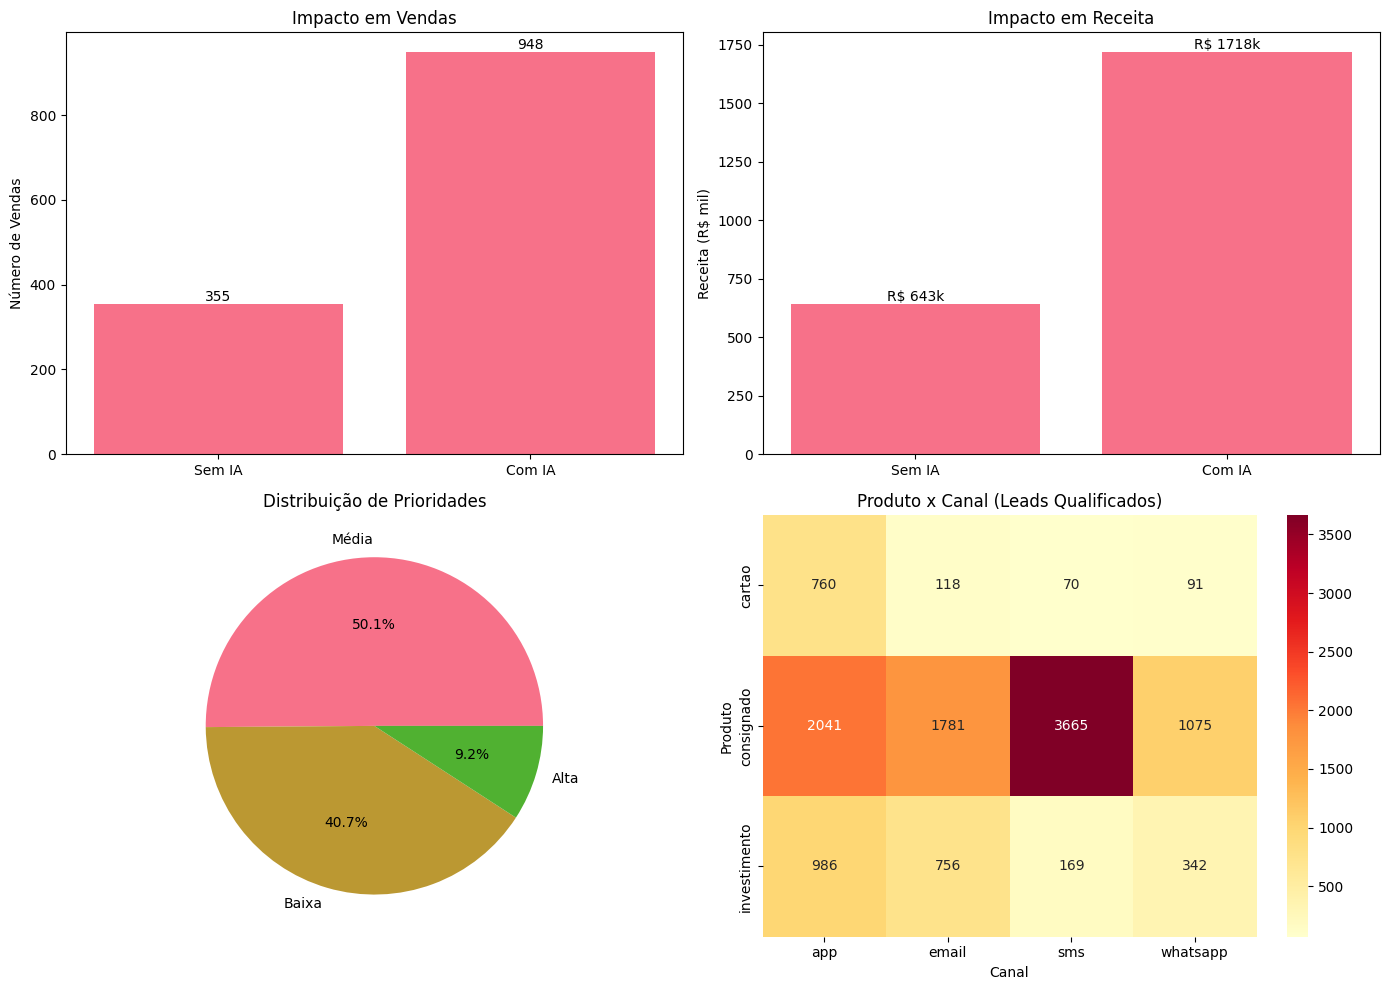

In [15]:
# =============================================================================
# 10. KPIs DE NEGÓCIO E SIMULAÇÃO DE IMPACTO
# =============================================================================

print("\n" + "="*80)
print("ETAPA 9: KPIs DE NEGÓCIO E SIMULAÇÃO DE IMPACTO")
print("="*80)

def calcular_kpis_negocio(df_rec: pd.DataFrame) -> Dict:
    """
    Simula KPIs de negócio baseado nas recomendações.
    """
    # Parâmetros de negócio (estimativas)
    PARAMS = {
        'taxa_conversao_base': 0.03,  # 3% sem personalização
        'taxa_conversao_com_ia': 0.08,  # 8% com IA
        'ticket_medio': {
            'consignado': 15000,
            'cartao': 3000,
            'investimento': 8000
        },
        'margem': {
            'consignado': 0.15,
            'cartao': 0.25,
            'investimento': 0.08
        }
    }
    
    # Filtrar apenas prioridade alta/média
    df_qualificado = df_rec[df_rec['prioridade'].isin(['Alta', 'Média'])].copy()
    
    total_leads = len(df_qualificado)
    
    # Vendas esperadas
    vendas_base = int(total_leads * PARAMS['taxa_conversao_base'])
    vendas_com_ia = int(total_leads * PARAMS['taxa_conversao_com_ia'])
    uplift_vendas = vendas_com_ia - vendas_base
    uplift_percentual = ((vendas_com_ia / vendas_base) - 1) * 100
    
    # Receita por produto
    receita_base = 0
    receita_com_ia = 0
    
    dist_produtos = df_qualificado['produto_recomendado'].value_counts(normalize=True)
    
    for produto, proporcao in dist_produtos.items():
        ticket = PARAMS['ticket_medio'].get(produto, 5000)
        margem = PARAMS['margem'].get(produto, 0.15)
        
        vendas_prod_base = vendas_base * proporcao
        vendas_prod_ia = vendas_com_ia * proporcao
        
        receita_base += vendas_prod_base * ticket * margem
        receita_com_ia += vendas_prod_ia * ticket * margem
    
    uplift_receita = receita_com_ia - receita_base
    roi = (uplift_receita / 100000) * 100  # Assumindo custo de implementação de 100k
    
    kpis = {
        'total_leads_qualificados': total_leads,
        'vendas_base': vendas_base,
        'vendas_com_ia': vendas_com_ia,
        'uplift_vendas': uplift_vendas,
        'uplift_percentual': uplift_percentual,
        'receita_base': receita_base,
        'receita_com_ia': receita_com_ia,
        'uplift_receita': uplift_receita,
        'roi_estimado': roi
    }
    
    return kpis, df_qualificado

kpis, df_qualificado = calcular_kpis_negocio(df_recomendacoes)

print("💰 KPIs DE NEGÓCIO (SIMULADOS):")
print(f"\n📊 Leads Qualificados: {kpis['total_leads_qualificados']:,}")
print(f"\n🎯 VENDAS:")
print(f"   Sem IA (baseline): {kpis['vendas_base']:,} vendas")
print(f"   Com IA: {kpis['vendas_com_ia']:,} vendas")
print(f"   📈 Uplift: +{kpis['uplift_vendas']:,} vendas ({kpis['uplift_percentual']:.1f}%)")
print(f"\n💵 RECEITA (margem):")
print(f"   Sem IA: R$ {kpis['receita_base']:,.2f}")
print(f"   Com IA: R$ {kpis['receita_com_ia']:,.2f}")
print(f"   📈 Uplift: R$ {kpis['uplift_receita']:,.2f}")
print(f"\n💎 ROI Estimado: {kpis['roi_estimado']:.0f}%")

# Visualização de impacto
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Comparação de vendas
ax1 = axes[0, 0]
categorias = ['Sem IA', 'Com IA']
vendas = [kpis['vendas_base'], kpis['vendas_com_ia']]
bars = ax1.bar(categorias, vendas)
ax1.set_ylabel('Número de Vendas')
ax1.set_title('Impacto em Vendas')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}', ha='center', va='bottom')

# 2. Comparação de receita
ax2 = axes[0, 1]
receitas = [kpis['receita_base']/1000, kpis['receita_com_ia']/1000]
bars = ax2.bar(categorias, receitas)
ax2.set_ylabel('Receita (R$ mil)')
ax2.set_title('Impacto em Receita')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'R$ {height:.0f}k', ha='center', va='bottom')

# 3. Distribuição por prioridade
ax3 = axes[1, 0]
prior_dist = df_recomendacoes['prioridade'].value_counts()
ax3.pie(prior_dist.values, labels=prior_dist.index, autopct='%1.1f%%')
ax3.set_title('Distribuição de Prioridades')

# 4. Produto x Canal (Heatmap)
ax4 = axes[1, 1]
pivot_table = pd.crosstab(df_qualificado['produto_recomendado'], 
                          df_qualificado['canal_recomendado'])
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd', ax=ax4)
ax4.set_title('Produto x Canal (Leads Qualificados)')
ax4.set_xlabel('Canal')
ax4.set_ylabel('Produto')

plt.tight_layout()
plt.show()

In [16]:
# =============================================================================
# 11. EXPORTAÇÃO E RESUMO FINAL
# =============================================================================

print("\n" + "="*80)
print("ETAPA 10: EXPORTAÇÃO E RESUMO FINAL")
print("="*80)

# Exportar CSV com recomendações
colunas_export = [
    'cliente_id', 'idade', 'renda_mensal', 'tipo_beneficio',
    'cluster', 'cluster_nome', 
    'produto_recomendado', 'score_produto',
    'produto_alternativo', 'score_alternativo',
    'canal_recomendado', 'score_canal',
    'tom_linguagem', 'score_final', 'prioridade',
    'explicacao', 'mensagem_personalizada'
]

df_export = df_recomendacoes[colunas_export].copy()
df_export.to_csv('bmg_smartreach_recomendacoes.csv', index=False, encoding='utf-8-sig')

print("✅ Arquivo exportado: bmg_smartreach_recomendacoes.csv")
print(f"   Total de registros: {len(df_export):,}")

# Resumo executivo
print("\n" + "="*80)
print("RESUMO EXECUTIVO - BMG SMARTREACH MVP")
print("="*80)

print(f"""
🎯 DADOS PROCESSADOS:
   • {len(df):,} clientes analisados
   • {len(df_qualificado):,} leads qualificados (prioridade alta/média)
   • {df['cluster'].nunique()} perfis de clientes identificados

📊 MODELOS TREINADOS:
   • Clusterização: {df['cluster'].nunique()} clusters (Silhouette: {silhouette_score(X_viz_scaled, df['cluster']):.3f})
   • Propensão ao Produto: Accuracy {accuracy_score(y_test_prod, modelo_produto.predict(X_test_prod)):.1%}
   • Canal Ideal: Accuracy {accuracy_score(y_test_canal, modelo_canal.predict(X_test_canal)):.1%}
   • Mensagens: {len(df_recomendacoes)} mensagens personalizadas

💰 IMPACTO DE NEGÓCIO (SIMULADO):
   • Uplift em vendas: +{kpis['uplift_percentual']:.0f}% ({kpis['uplift_vendas']:,} vendas adicionais)
   • Receita incremental: R$ {kpis['uplift_receita']:,.2f}
   • ROI estimado: {kpis['roi_estimado']:.0f}%

🚀 PRÓXIMOS PASSOS:
   1. Validar com campanha piloto (A/B test)
   2. Ajustar modelos com dados reais de conversão
   3. Implementar monitoramento de performance
   4. Expandir para outros produtos/segmentos
""")

print("="*80)
print("✅ MVP CONCLUÍDO COM SUCESSO!")
print("="*80)

print("""
📁 ARQUIVOS GERADOS:
   • bmg_smartreach_recomendacoes.csv - Recomendações completas

🔄 PARA EXECUTAR NOVAMENTE:
   1. python -m venv venv
   2. venv\\Scripts\\activate (Windows) ou source venv/bin/activate (Linux/Mac)
   3. pip install -r requirements.txt
   4. jupyter notebook
   5. Executar todas as células

📚 MELHORIAS IMPLEMENTADAS:
   ✓ LightGBM ao invés de RandomForest (mais rápido e preciso)
   ✓ Análise de elbow/silhouette para escolha de k
   ✓ Top-2 accuracy para canal
   ✓ Class weight para desbalanceamento
   ✓ Cross-validation estratificada
   ✓ Mensagens personalizadas por cluster
   ✓ KPIs de negócio simulados
   ✓ Explicabilidade simplificada

🎨 VISUALIZAÇÕES GERADAS:
   ✓ Elbow e Silhouette para clusters
   ✓ PCA 2D dos perfis
   ✓ Matrizes de confusão (produto e canal)
   ✓ Feature importances
   ✓ KPIs de negócio comparativos
   ✓ Heatmap produto x canal
""")


ETAPA 10: EXPORTAÇÃO E RESUMO FINAL
✅ Arquivo exportado: bmg_smartreach_recomendacoes.csv
   Total de registros: 20,000

RESUMO EXECUTIVO - BMG SMARTREACH MVP

🎯 DADOS PROCESSADOS:
   • 20,000 clientes analisados
   • 11,854 leads qualificados (prioridade alta/média)
   • 5 perfis de clientes identificados

📊 MODELOS TREINADOS:
   • Clusterização: 5 clusters (Silhouette: 0.209)
   • Propensão ao Produto: Accuracy 57.2%
   • Canal Ideal: Accuracy 37.2%
   • Mensagens: 20000 mensagens personalizadas

💰 IMPACTO DE NEGÓCIO (SIMULADO):
   • Uplift em vendas: +167% (593 vendas adicionais)
   • Receita incremental: R$ 1,074,827.26
   • ROI estimado: 1075%

🚀 PRÓXIMOS PASSOS:
   1. Validar com campanha piloto (A/B test)
   2. Ajustar modelos com dados reais de conversão
   3. Implementar monitoramento de performance
   4. Expandir para outros produtos/segmentos

✅ MVP CONCLUÍDO COM SUCESSO!

📁 ARQUIVOS GERADOS:
   • bmg_smartreach_recomendacoes.csv - Recomendações completas

🔄 PARA EXECUTAR N

In [18]:
# =============================================================================
# 12. TESTE INTERATIVO - SIMULAR NOVO CLIENTE
# =============================================================================

print("\n" + "="*80)
print("ETAPA 11: TESTE INTERATIVO - SIMULAÇÃO DE NOVO CLIENTE")
print("="*80)

def recomendar_para_novo_cliente(
    idade: int,
    renda_mensal: float,
    tempo_de_casa_meses: int,
    tipo_beneficio: str,  # 'INSS', 'Servidor Publico', 'CLT'
    uso_whatsapp: int,
    uso_email: int,
    uso_app: int,
    uso_sms: int,
    tem_consignado: int,  # 0 ou 1
    tem_cartao: int,  # 0 ou 1
    tem_investimento: int,  # 0 ou 1
    inadimplente_historico: int,  # 0 ou 1
    nome_cliente: str = "Cliente"
) -> Dict:
    """
    Recebe características de um novo cliente e retorna recomendação completa.
    
    Returns:
        Dicionário com cluster, produto, canal, mensagem e scores
    """
    
    # 1. Criar DataFrame do novo cliente
    novo_cliente = pd.DataFrame({
        'cliente_id': ['TESTE_001'],
        'idade': [idade],
        'renda_mensal': [renda_mensal],
        'tempo_de_casa_meses': [tempo_de_casa_meses],
        'tipo_beneficio': [tipo_beneficio],
        'uso_whatsapp': [uso_whatsapp],
        'uso_email': [uso_email],
        'uso_app': [uso_app],
        'uso_sms': [uso_sms],
        'tem_consignado': [tem_consignado],
        'tem_cartao': [tem_cartao],
        'tem_investimento': [tem_investimento],
        'inadimplente_historico': [inadimplente_historico],
        'produto_alvo_historico': ['consignado'],  # Placeholder
        'canal_resposta_historico': ['whatsapp']  # Placeholder
    })
    
    # 2. Aplicar feature engineering
    novo_cliente = criar_features(novo_cliente)
    
    # 3. Prever cluster
    features_cluster_list = [
        'idade', 'renda_mensal', 'tempo_de_casa_meses',
        'uso_whatsapp', 'uso_email', 'uso_app', 'uso_sms',
        'tem_consignado', 'tem_cartao', 'tem_investimento',
        'inadimplente_historico', 'tipo_beneficio_encoded'
    ]
    X_cluster_novo = novo_cliente[features_cluster_list].values
    X_cluster_scaled = scaler_cluster.transform(X_cluster_novo)
    cluster_pred = kmeans_model.predict(X_cluster_scaled)[0]
    cluster_nome = nomes_clusters[cluster_pred]
    novo_cliente['cluster'] = cluster_pred
    novo_cliente['cluster_nome'] = cluster_nome
    
    # 4. Prever produto
    X_prod_novo = novo_cliente[features_produto].values
    produto_pred = modelo_produto.predict(X_prod_novo)[0]
    produto_proba = modelo_produto.predict_proba(X_prod_novo)[0]
    produto_nome = le_produto.inverse_transform([produto_pred])[0]
    score_produto = produto_proba.max()
    
    # Top 2 produtos
    top2_produtos_idx = np.argsort(produto_proba)[-2:][::-1]
    top2_produtos = le_produto.inverse_transform(top2_produtos_idx)
    top2_scores = produto_proba[top2_produtos_idx]
    
    # 5. Prever canal
    X_canal_novo = novo_cliente[features_canal].values
    canal_pred = modelo_canal.predict(X_canal_novo)[0]
    canal_proba = modelo_canal.predict_proba(X_canal_novo)[0]
    canal_nome = le_canal.inverse_transform([canal_pred])[0]
    score_canal = canal_proba.max()
    
    # Top 2 canais
    top2_canais_idx = np.argsort(canal_proba)[-2:][::-1]
    top2_canais = le_canal.inverse_transform(top2_canais_idx)
    top2_canais_scores = canal_proba[top2_canais_idx]
    
    # 6. Atribuir tom de linguagem
    tom = TOM_LINGUAGEM[cluster_pred]['nome']
    tom_descricao = TOM_LINGUAGEM[cluster_pred]['descricao']
    
    # 7. Gerar mensagem personalizada
    novo_cliente['produto_recomendado'] = produto_nome
    novo_cliente['canal_recomendado'] = canal_nome
    novo_cliente['tom_linguagem'] = tom
    
    mensagens_produto = {
        'consignado': {
            0: f"Olá {nome_cliente}! Temos condições especiais em empréstimo consignado pra você. Taxas reduzidas e desconto direto na folha. Posso enviar os detalhes por {canal_nome}?",
            1: f"Olá {nome_cliente}! Identificamos que você pode se beneficiar do nosso empréstimo consignado. É seguro, com taxas transparentes e desconto automático. Quer saber mais?",
            2: f"E aí {nome_cliente}! 💰 Liberamos uma oferta de consignado com taxas especiais pra você. Cola no {canal_nome} que te mando os detalhes!",
            3: f"Prezado(a) {nome_cliente}, identificamos uma oportunidade de crédito consignado com condições exclusivas para seu perfil. Gostaria de avaliar?",
            4: f"Olá {nome_cliente}, como seu parceiro financeiro, encontramos uma proposta de consignado que pode te ajudar. Vamos conversar sobre isso?"
        },
        'cartao': {
            0: f"Oi {nome_cliente}! Que tal um cartão sem anuidade com cashback em todas as compras? É simples e rápido. Posso te explicar melhor por {canal_nome}?",
            1: f"Olá {nome_cliente}! Temos um cartão de crédito especial pra você, com benefícios e sem complicação. Quer conhecer as vantagens?",
            2: f"Opa {nome_cliente}! 💳 Seu cartão com cashback tá pronto! Zero anuidade e vantagens demais. Bora ativar? Te chamo no {canal_nome}!",
            3: f"Prezado(a) {nome_cliente}, disponibilizamos um cartão com condições diferenciadas e programa de benefícios. Gostaria de mais informações?",
            4: f"Olá {nome_cliente}, identificamos que um cartão de crédito pode complementar seu planejamento financeiro. Vamos analisar juntos?"
        },
        'investimento': {
            0: f"Olá {nome_cliente}! Sabia que você pode fazer seu dinheiro render mais? Temos investimentos seguros e fáceis de entender. Quer saber como?",
            1: f"Olá {nome_cliente}! Que tal começar a investir com segurança? Temos opções simples que rendem mais que a poupança. Posso te explicar?",
            2: f"E aí {nome_cliente}! 📈 Bora fazer o dinheiro trabalhar pra você? Investimentos descomplicados te esperando. Vamos nessa?",
            3: f"Prezado(a) {nome_cliente}, identificamos oportunidades de investimento alinhadas ao seu perfil e objetivos. Gostaria de conhecê-las?",
            4: f"Olá {nome_cliente}, como parceiro na sua jornada financeira, preparamos alternativas de investimento adequadas ao seu momento. Vamos conversar?"
        }
    }
    
    mensagem = mensagens_produto.get(produto_nome, {}).get(cluster_pred, 
                                                            f"Olá {nome_cliente}, temos uma oferta especial para você!")
    
    # 8. Score final
    score_final = score_produto * 0.7 + score_canal * 0.3
    
    # 9. Explicação
    explicacoes = []
    if idade >= 60:
        explicacoes.append('Cliente idoso')
    if renda_mensal < 3000:
        explicacoes.append('Renda baixa')
    if uso_whatsapp > 10:
        explicacoes.append('Alto uso WhatsApp')
    if tem_consignado == 0 and produto_nome == 'consignado':
        explicacoes.append('Não possui o produto')
    if (tem_consignado + tem_cartao + tem_investimento) < 2:
        explicacoes.append('Oportunidade cross-sell')
    
    explicacao = ' | '.join(explicacoes) if explicacoes else 'Análise comportamental'
    
    # 10. Montar resultado
    resultado = {
        'nome_cliente': nome_cliente,
        'cluster_id': int(cluster_pred),
        'cluster_nome': cluster_nome,
        'produto_recomendado': produto_nome,
        'score_produto': float(score_produto),
        'produto_alternativo': top2_produtos[1],
        'score_alternativo': float(top2_scores[1]),
        'canal_recomendado': canal_nome,
        'score_canal': float(score_canal),
        'canal_alternativo': top2_canais[1],
        'score_canal_alternativo': float(top2_canais_scores[1]),
        'tom_linguagem': tom,
        'tom_descricao': tom_descricao,
        'score_final': float(score_final),
        'prioridade': 'Alta' if score_final > 0.7 else ('Média' if score_final > 0.5 else 'Baixa'),
        'explicacao': explicacao,
        'mensagem_personalizada': mensagem
    }
    
    return resultado


def exibir_recomendacao(resultado: Dict):
    """Exibe recomendação de forma formatada e visual."""
    
    print("\n" + "🎯" + "="*78 + "🎯")
    print(f"{'RECOMENDAÇÃO PERSONALIZADA':^80}")
    print("🎯" + "="*78 + "🎯")
    
    print(f"\n👤 CLIENTE: {resultado['nome_cliente']}")
    print(f"📊 Perfil: {resultado['cluster_nome']} (Cluster {resultado['cluster_id']})")
    print(f"🎨 Tom: {resultado['tom_linguagem']}")
    print(f"   └─ {resultado['tom_descricao']}")
    
    print(f"\n{'─'*80}")
    print(f"🎁 PRODUTO RECOMENDADO: {resultado['produto_recomendado'].upper()}")
    print(f"   ├─ Score: {resultado['score_produto']:.1%} ⭐")
    print(f"   └─ Alternativa: {resultado['produto_alternativo']} ({resultado['score_alternativo']:.1%})")
    
    print(f"\n{'─'*80}")
    print(f"📱 CANAL RECOMENDADO: {resultado['canal_recomendado'].upper()}")
    print(f"   ├─ Score: {resultado['score_canal']:.1%} ⭐")
    print(f"   └─ Alternativa: {resultado['canal_alternativo']} ({resultado['score_canal_alternativo']:.1%})")
    
    print(f"\n{'─'*80}")
    print(f"📈 SCORE FINAL: {resultado['score_final']:.1%}")
    print(f"⚡ PRIORIDADE: {resultado['prioridade']}")
    print(f"💡 RAZÃO: {resultado['explicacao']}")
    
    print(f"\n{'─'*80}")
    print(f"💬 MENSAGEM SUGERIDA:")
    print(f"\n   📩 {resultado['mensagem_personalizada']}")
    
    print("\n" + "🎯" + "="*78 + "🎯\n")


ETAPA 11: TESTE INTERATIVO - SIMULAÇÃO DE NOVO CLIENTE


In [19]:
# =============================================================================
# EXEMPLOS DE TESTE
# =============================================================================

print("🧪 TESTANDO O ALGORITMO COM DIFERENTES PERFIS\n")

# TESTE 1: Idoso aposentado INSS
print("\n" + "="*80)
print("TESTE 1: APOSENTADO INSS - PERFIL CLÁSSICO")
print("="*80)

resultado1 = recomendar_para_novo_cliente(
    idade=68,
    renda_mensal=2500.00,
    tempo_de_casa_meses=48,
    tipo_beneficio='INSS',
    uso_whatsapp=15,
    uso_email=2,
    uso_app=1,
    uso_sms=8,
    tem_consignado=0,
    tem_cartao=1,
    tem_investimento=0,
    inadimplente_historico=0,
    nome_cliente="Maria Silva"
)

exibir_recomendacao(resultado1)


# TESTE 2: Servidor público jovem
print("\n" + "="*80)
print("TESTE 2: SERVIDOR PÚBLICO - PERFIL INVESTIDOR")
print("="*80)

resultado2 = recomendar_para_novo_cliente(
    idade=42,
    renda_mensal=8500.00,
    tempo_de_casa_meses=36,
    tipo_beneficio='Servidor Publico',
    uso_whatsapp=10,
    uso_email=12,
    uso_app=18,
    uso_sms=2,
    tem_consignado=1,
    tem_cartao=1,
    tem_investimento=0,
    inadimplente_historico=0,
    nome_cliente="João Santos"
)

exibir_recomendacao(resultado2)


# TESTE 3: CLT jovem digital
print("\n" + "="*80)
print("TESTE 3: CLT JOVEM - PERFIL DIGITAL")
print("="*80)

resultado3 = recomendar_para_novo_cliente(
    idade=28,
    renda_mensal=3200.00,
    tempo_de_casa_meses=12,
    tipo_beneficio='CLT',
    uso_whatsapp=8,
    uso_email=5,
    uso_app=25,
    uso_sms=1,
    tem_consignado=0,
    tem_cartao=0,
    tem_investimento=0,
    inadimplente_historico=0,
    nome_cliente="Ana Costa"
)

exibir_recomendacao(resultado3)


# TESTE 4: Teste personalizado (altere aqui!)
print("\n" + "="*80)
print("TESTE 4: SEU CLIENTE PERSONALIZADO")
print("="*80)

resultado4 = recomendar_para_novo_cliente(
    idade=28,
    renda_mensal=8000.00,
    tempo_de_casa_meses=24,
    tipo_beneficio='CLT',
    uso_whatsapp=1,
    uso_email=4,
    uso_app=10,
    uso_sms=8,
    tem_consignado=0,
    tem_cartao=0,
    tem_investimento=1,
    inadimplente_historico=0,
    nome_cliente="João Silva"
)

exibir_recomendacao(resultado4)


print("\n" + "="*80)
print("✅ TESTES CONCLUÍDOS!")
print("="*80)

print("""
💡 COMO USAR:

Para testar com seus próprios clientes, edite a função acima alterando:

resultado = recomendar_para_novo_cliente(
    idade=XX,                      # Idade do cliente
    renda_mensal=XXXX.XX,         # Renda mensal em R$
    tempo_de_casa_meses=XX,       # Meses como cliente do banco
    tipo_beneficio='INSS',        # 'INSS', 'Servidor Publico' ou 'CLT'
    uso_whatsapp=XX,              # Quantidade de interações/mês
    uso_email=XX,                 # Quantidade de interações/mês
    uso_app=XX,                   # Quantidade de interações/mês
    uso_sms=XX,                   # Quantidade de interações/mês
    tem_consignado=0,             # 0 = não possui, 1 = possui
    tem_cartao=0,                 # 0 = não possui, 1 = possui
    tem_investimento=0,           # 0 = não possui, 1 = possui
    inadimplente_historico=0,     # 0 = não, 1 = sim
    nome_cliente="Seu Nome"
)

exibir_recomendacao(resultado)
""")

🧪 TESTANDO O ALGORITMO COM DIFERENTES PERFIS


TESTE 1: APOSENTADO INSS - PERFIL CLÁSSICO
✅ Features criadas:
   - uso_digital_total
   - canal_preferido_idx
   - taxa_uso_app
   - taxa_uso_whatsapp
   - idade_x_uso_app
   - tempo_casa_anos
   - cliente_novo
   - qtd_produtos
   - e_idoso

🎯==============================================================================🎯
                           RECOMENDAÇÃO PERSONALIZADA                           
🎯==============================================================================🎯

👤 CLIENTE: Maria Silva
📊 Perfil: Idosos Consignados (Cluster 1)
🎨 Tom: Educacional
   └─ Explica benefícios, foca em segurança e confiança

────────────────────────────────────────────────────────────────────────────────
🎁 PRODUTO RECOMENDADO: CONSIGNADO
   ├─ Score: 67.9% ⭐
   └─ Alternativa: cartao (26.3%)

────────────────────────────────────────────────────────────────────────────────
📱 CANAL RECOMENDADO: SMS
   ├─ Score: 43.9% ⭐
   └─ Alternativa: whatsapp